In [44]:
import scipy.io
import pandas as pd
import numpy as np
import pickle
import cdt
import networkx as nx
import matplotlib.pyplot as plt

In [31]:
d1_mat = scipy.io.loadmat('D1.mat')
d1 = pd.DataFrame(d1_mat['D'])

0      1.653125
1     -2.311674
2      0.455422
3      0.528860
4     -0.630586
         ...   
495    1.600222
496    1.073287
497   -3.382424
498   -0.197045
499   -0.853171
Name: 1, Length: 500, dtype: float64

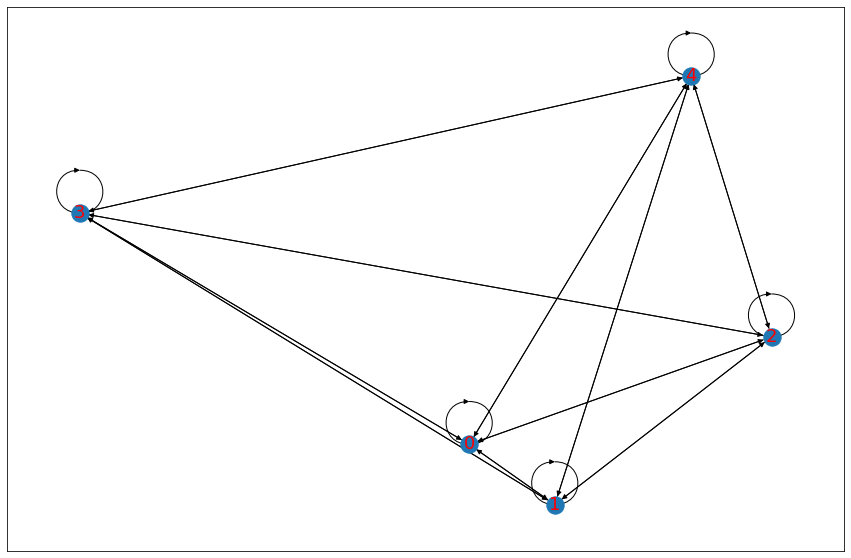

In [35]:
# intialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to dataset
skeleton = glasso.predict(d1)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

In [45]:
model_pc = cdt.causality.graph.PC()
# graph_pc = model_pc.predict(df)
graph_pc = model_pc.predict(d1, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r')

# get adjaceny matrix of PC graph
A_pc = nx.adjacency_matrix(graph_pc).todense()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mbela\\miniconda3\\envs\\finance37\\lib\\site-packages\\cdt\\utils\\R_templates\\test_import.R'